# How many DESI mocks do we need for a full fit to all data?

This notebook contains some notes/code to give estimates for how many mock galaxy catalogues we might need to fit all the DESI redshift bins simultaneously for cosmological parameters. 

When estimating covariance matrices from an ensemble of simulations there are several issues that arise. As pointed out in [Hartlap & Schneider 2007](https://ui.adsabs.harvard.edu/abs/2007A%26A...464..399H/abstract), the inverse of a sample covariance matrix estimated from simulations $C^{-1}$ (which we have) is **not** an unbiased estimator of the true precision matrix $\Psi$ (which we want to use in our likelihood). However, this bias can be accounted for easily using $\Psi = (1 - D)C^{-1}$, where $$D = \frac{n_{b}+1}{n_{s}-1},$$ $n_{b}$ is the length of the data vector we want to fit (i.e., $C^{-1}$ has dimensions $n_{b} \times n_{b}$) and $n_{s}$ is the number of simulations we have at our disposal.

However, this is not the end of the story. In addition to the inverse covariance being biased, the presence of noise in our estimate of the covariance should also contribute to the covariance for our parameters. When using the matrix $\Psi$ above, we are neglecting this noise, and hence underestimating our parameter errors. To account for this, [Percival et. al., 2013](https://ui.adsabs.harvard.edu/abs/2014MNRAS.439.2531P/abstract) showed that the variance on the model parameters you are fitting should be increased by $$m_{1} = \frac{1 + B(n_{b}-n_{p})}{1 + A + B(n_{p}+1)},$$ where $n_{p}$ is the number of free parameters in your model, $$A=\frac{2}{(n_{s}-n_{b}-1)(n_{s}-n_{b}-4)} \quad \mathrm{and} \quad B=\frac{n_{s}-n_{b}-2}{(n_{s}-n_{b}-1)(n_{s}-n_{b}-4)}.$$

Finally, there is one other subtle consideration. Although the above expression tells us how much we should increase the variance in the recovered parameter constraints due to the the fact we are using an estimate of the true covariance matrix, it does not represent a full marginalisation over the unknown covariance matrix. This is demonstrated in [Sellentin & Heavens 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456L.132S/abstract). While we often use the (corrected) inverse covariance matrix in a Gaussian likelihood function for the log-likelihood $$\mathrm{ln}\mathcal{L} \propto -\frac{1}{2}\chi^{2}$$ then scale the parameter uncertainties by $\sqrt{m_{1}}$, in reality the full marginalisation over the PDF for a true covariance matrix given our estimated one means we should be using a likelihood like $$\mathrm{ln}\mathcal{L} \propto -\frac{n_{s}}{2}\mathrm{ln}\biggl[1 + \frac{\chi^{2}}{n_{s}-1}\biggl].$$ 

rather than debiasing the inverse covariance and increasing the parameter errors by numerical factors. This likelihood only reduces to the Gaussian loglikelihood in the limit $n_{s}\Rightarrow \infty$.

This notebook computes the $D$ and $m_{1}$ factors above, as well as the ratio between the two forms of the log-likelihood for a few representative $\Delta \chi^{2}$, for varying numbers of mocks and data points. It's set up to consider DESI redshift bins and analysis styles.

Let's start out with some assumptions as a first pass:
* Fit the Power spectrum multipoles $\ell=0$, $2$, $4$ up to different $k_{max}$ with some $\Delta k$ - estimates should also be appropriate for correlation function. Ignore odd multipoles.
* First k-bin is at $\Delta k$. Assumes this is not so small (large scale) we'd want to remove it.
* Keep NGC and SGC as two separate components - no need to include covariance between these? If yes, set NGC_SGC_cross_cov = True.
* Fit multi-tracer where tracers overlap - included as a multiplicative factor below to test impact of this.
* Don't include Ly$\alpha$ mocks here.
* Assume we are fitting wCDM cosmology with an EFT-based model, but with fixed $\tau$, so 6 cosmo params, 10 bias. Change via n_cosmo and n_nuisance_per_z_bin_per_tracer.

First, let's compute the length of the data-vector in each redshift bin

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
from scipy.stats import norm, chi2
from scipy.optimize import minimize

delta_k = 0.01                          # k-bin width. Reasonable choice, but could go wider if necessary
k_max = np.array([0.20, 0.20, 0.15])    # Seems reasonable for what we might want to look at.
NGC_SGC_cross_cov = False               # NGC and SGC separate.
BGS_z_bins = 5                          # Split BGS into 5 bins of delta_z = 0.1, between 0.0 and 0.5
Baseline_z_bins = 14                    # Baseline survey split into 14 bins of delta_z = 0.1, between 0.5 and 1.9
pre_and_post_recon = False              # Account for if we want to jointly fit pre- and post-reconstruction measurements.
n_cosmo = 6                             # Number of cosmological free parameters - As, omega_b*h^2, omega_cdm*h^2, H0, n_s, w.
n_nuisance_per_z_bin_per_tracer = 10    # Number of nuisance parameters per redshift bin per tracer - b1, b2, b3, b4, 3 x counter-terms, 3 x stochastic, 
                                        # not sure about cross-power but let's not add additional free params for these for now.

# We might want to do multi-tracer in BGS, so let's include a factor for this
BGS_multi_tracer_factor = np.array([1, 1, 1, 1, 1])

# Multiplicative factors for multi-tracer in each of the Baseline z_bins - where there are two tracers, assume P_aa, P_ab, P_bb are measured and fit. 
# Where there are three tracers, we have P_aa, P_ab, P_ac, P_bb, P_bc, P_cc. The number specified in the vector is the number of tracers.
Baseline_multi_tracer_factor = np.array([2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1])

# So how many data points and nuisance parameters do we have in each redshift bin?
sky_patches = 2 if NGC_SGC_cross_cov else 1
pre_and_post_factor = 2 if pre_and_post_recon is True else 1
Nk_per_bin = np.sum((k_max/delta_k).astype(int)) * sky_patches * pre_and_post_factor
Nk_BGS = Nk_per_bin * np.array([np.sum(np.arange(i+1)) for i in BGS_multi_tracer_factor])
Nk_Baseline = Nk_per_bin * np.array([np.sum(np.arange(i+1)) for i in Baseline_multi_tracer_factor])
N_nuisance_BGS = n_nuisance_per_z_bin_per_tracer * BGS_multi_tracer_factor
N_nuisance_Baseline = n_nuisance_per_z_bin_per_tracer * Baseline_multi_tracer_factor

print("BGS data vector length in each z-bin\n", Nk_BGS, "\n")
print("BGS number of nuisance parameters in each z-bin\n", N_nuisance_BGS, "\n")
print("Baseline data vector length in each z-bin\n", Nk_Baseline, "\n")
print("Baseline number of nuisance parameters in each z-bin\n", N_nuisance_Baseline, "\n")

# Finally, let's define some threshold's for D, m1 and the likelihood ratio we would like to adhere to
threshold_D = 0.05         # Hartlap correction no larger than 5%
threshold_sqrt_m1 = 1.01   # This is the threshold in the standard_deviation - so currently set to no larger than 1% increase.
threshold_logL = 0.95      # Gaussian and Sellentin likelihoods agree to 95%

BGS data vector length in each z-bin
 [55 55 55 55 55] 

BGS number of nuisance parameters in each z-bin
 [10 10 10 10 10] 

Baseline data vector length in each z-bin
 [165 330 330 330 330 330 330 165 165 165 165 165  55  55] 

Baseline number of nuisance parameters in each z-bin
 [20 30 30 30 30 30 30 20 20 20 20 20 10 10] 



That's quite a lot of measurement bins, especially where we want to include multi-tracer fits and pre+post-recon! 

As a first estimate, let's assume we want to produce enough mocks to estimate a covariance matrix for everything in one go, combining BGS and Baseline. This is clearly going to require a lot of sims... Let's compute the Hartlap factor $D$, Percival $m_{1}$ factor, and compare difference between the full marginalised Sellentin & Heavens log-likelihood to the Gaussian at a fixed distance from the maximum likelihood - for this comparison let's go for Gaussian 1, 2 and 3$\sigma$. We can then set thresholds for these to estimate the minimum number of mocks - horizontal lines are drawn at the thresholds defined above. The computation and plotting code is hidden behind the dots if you want to modify this.

There are three functions. In all cases, Nb and Np must be a list (even if they are only single numbers) and each element in the list is called a 'Scenario'.
* **computation(N_sims, Nb, Np, do_print=True)** - This will print the factors for the number of mocks (where N_sims is a single number or array), and state whether the thresholds are met for each number of sims
* **plot_things(N_sims, Nb, Np)** - This will plot the factors as a function of number of simulations
* **how_many_mocks(Nb, Np)** - This will work out the minimum number of simulations needed to pass the threshold for each Scenario

In [173]:
def computation(N_sims, Nb, Np, do_print=False):

    Hartlap_D = [(Nb_i + 1.0)/(N_sims - 1.0) for Nb_i in Nb]
    Percival_A = [2.0/((N_sims - Nb_i - 1.0) * (N_sims - Nb_i - 4.0)) for Nb_i in Nb]
    Percival_B = [(N_sims - Nb_i - 2.0)/((N_sims - Nb_i - 1.0) * (N_sims - Nb_i - 4.0)) for Nb_i in Nb]
    Percival_m1 = [(1.0 + Percival_B_i*(Nb_i - Np_i))/(1.0 + Percival_A_i + Percival_B_i*(Np_i + 1.0)) for (Percival_A_i, Percival_B_i, Nb_i, Np_i) in zip(Percival_A, Percival_B, Nb, Np)]

    # What are the exact percentage thresholds for a standard 1D Gaussian?
    # Hence what are the chi_squared thresholds for a multivariate Gaussian with Nb degrees of freedom.
    percentages = norm().cdf([1.0, 2.0, 3.0]) - norm().cdf([-1.0, -2.0, -3.0])
    delta_chi = [chi2(Nb_i).ppf(percentages) for Nb_i in Nb]
    Gaussian = [- 0.5 * delta_chi_i for delta_chi_i in delta_chi]
    Sellentin = [-N_sims/2.0 * np.log(1.0 + np.outer(delta_chi_i, 1.0/(N_sims - 1.0))) for delta_chi_i in delta_chi]
    
    if do_print:
        for i, (D, m1, Sell, Gauss) in enumerate(zip(Hartlap_D, Percival_m1, Sellentin, Gaussian)):
            if np.any(D > 1):
                print("WARNING - Unphysical scenarios present (data vector larger than N_sims)")
            D_pass = D < threshold_D
            m1_pass = m1 < threshold_sqrt_m1**2
            logL_pass = (Sell[0]/Gauss[0] > threshold_logL) & (Sell[1]/Gauss[1] > threshold_logL) & (Sell[2]/Gauss[2] > threshold_logL)
            print("Scenario %d\n-----------------" % (i + 1))
            print("Hartlap D Factor\n", D, "\n")
            print("Percival m1 Factor\n", m1, "\n")
            print("Sellentin/Gaussian Ratio (1-sigma)\n", Sell[0]/Gauss[0], "\n")
            print("Sellentin/Gaussian Ratio (2-sigma)\n", Sell[1]/Gauss[1], "\n")
            print("Sellentin/Gaussian Ratio (3-sigma)\n", Sell[2]/Gauss[2], "\n")
            print("Passes Thresholds?\n", D_pass & m1_pass & logL_pass, "\n")

    return Hartlap_D, Percival_m1, Gaussian, Sellentin
    
def plot_things(N_sims, Nb, Np):
      
    Hartlap_D, Percival_m1, Gaussian, Sellentin = computation(N_sims, Nb, Np)
    
    ls = ['-', '--']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
    for i, D in enumerate(Hartlap_D):
        ax1.loglog(N_sims, D, ls=ls[i])
    ax1.axhline(y = threshold_D, c='k', ls=":")
    ax1.set_xlabel(r'$N_{\mathrm{simulations}}$', fontsize=16)
    ax1.set_ylabel(r'$D$', fontsize=16)
    ax1.tick_params(width=1.3)
    ax1.tick_params('both',length=10, which='major')
    ax1.tick_params('both',length=5, which='minor')
    for axis in ['top','left','bottom','right']:
        ax1.spines[axis].set_linewidth(1.3)
    for tick in ax1.xaxis.get_ticklabels():
        tick.set_fontsize(14)
    for tick in ax1.yaxis.get_ticklabels():
        tick.set_fontsize(14)
    ax1.yaxis.set_major_formatter(tk.ScalarFormatter())

    for i, m1 in enumerate(Percival_m1):
        ax2.loglog(N_sims, np.sqrt(m1)-1.0, ls=ls[i])
    ax2.axhline(y = threshold_sqrt_m1-1.0, c='k', ls=":")
    ax2.set_xlabel(r'$N_{\mathrm{simulations}}$', fontsize=14)
    ax2.set_ylabel(r'$\sqrt{m_{1}} - 1$', fontsize=14)
    ax2.tick_params(width=1.3)
    ax2.tick_params('both',length=10, which='major')
    ax2.tick_params('both',length=5, which='minor')
    for axis in ['top','left','bottom','right']:
        ax2.spines[axis].set_linewidth(1.3)
    for tick in ax2.xaxis.get_ticklabels():
        tick.set_fontsize(14)
    for tick in ax2.yaxis.get_ticklabels():
        tick.set_fontsize(14)

    for i, (Sell, Gauss) in enumerate(zip(Sellentin, Gaussian)):
        if i == 0:
            ax3.semilogx(N_sims, Sell[0]/Gauss[0], label=r"$1\sigma$", c=colors[0], ls=ls[i])
            ax3.semilogx(N_sims, Sell[1]/Gauss[1], label=r"$2\sigma$", c=colors[1], ls=ls[i])
            ax3.semilogx(N_sims, Sell[2]/Gauss[2], label=r"$3\sigma$", c=colors[2], ls=ls[i])
        else:
            ax3.semilogx(N_sims, Sell[0]/Gauss[0], c=colors[0], ls=ls[i])
            ax3.semilogx(N_sims, Sell[1]/Gauss[1], c=colors[1], ls=ls[i])
            ax3.semilogx(N_sims, Sell[2]/Gauss[2], c=colors[2], ls=ls[i])
    ax3.axhline(y = threshold_logL, c='k', ls=":")
    ax3.set_xlabel(r'$N_{\mathrm{simulations}}$', fontsize=14)
    ax3.set_ylabel(r'$\Delta \mathrm{Ln}\mathcal{L}_{\mathrm{Sellentin}}/\Delta \mathrm{Ln}\mathcal{L}_{\mathrm{Gaussian}}$', fontsize=14)
    ax3.tick_params(width=1.3)
    ax3.tick_params('both',length=10, which='major')
    ax3.tick_params('both',length=5, which='minor')
    for axis in ['top','left','bottom','right']:
        ax3.spines[axis].set_linewidth(1.3)
    for tick in ax3.xaxis.get_ticklabels():
        tick.set_fontsize(14)
    for tick in ax3.yaxis.get_ticklabels():
        tick.set_fontsize(14)
    ax3.legend(fontsize=14)

    fig.tight_layout()
    
def how_many_mocks(Nb, Np):
    
    def minfunc(N_sims, Nb, Np):
        if N_sims < 0:
            return 1.0e30
        D, m1, Gauss, Sell = computation(N_sims, Nb, Np)
        D_pass = D[0] < threshold_D
        m1_pass = m1[0] < threshold_sqrt_m1**2
        logL_pass = (Sell[0][0]/Gauss[0][0] > threshold_logL) & (Sell[0][1]/Gauss[0][1] > threshold_logL) & (Sell[0][2]/Gauss[0][2] > threshold_logL)
        if D_pass & m1_pass & logL_pass:
            return N_sims
        else:
            return 1.0e30
        
    for i, (Nb_i, Np_i) in enumerate(zip(Nb, Np)):
        result = np.ceil(minimize(minfunc, 1.0e10, args=([Nb_i], [Np_i]), method="Nelder-Mead").x)
        print("Scenario %d needs at least %d mocks" % (i + 1, int(result)))

## Single large covariance matrix estimation for BGS and Baseline - Least efficient.

WARNING - Unphysical scenarios present (data vector larger than N_sims)
Scenario 1
-----------------
Hartlap D Factor
 [3.35935936 1.67883942] 

Percival m1 Factor
 [-0.31347847 -1.65239702] 

Sellentin/Gaussian Ratio (1-sigma)
 [0.43639848 0.58486629] 

Sellentin/Gaussian Ratio (2-sigma)
 [0.43027498 0.57856614] 

Sellentin/Gaussian Ratio (3-sigma)
 [0.42484712 0.57294328] 

Passes Thresholds?
 [False False] 



<ipython-input-173-452139dbe7f0>:13: RuntimeWarning: invalid value encountered in log
  Sellentin = [-N_sims/2.0 * np.log(1.0 + np.outer(delta_chi_i, 1.0/(N_sims - 1.0))) for delta_chi_i in delta_chi]


Scenario 1 needs at least 132434 mocks


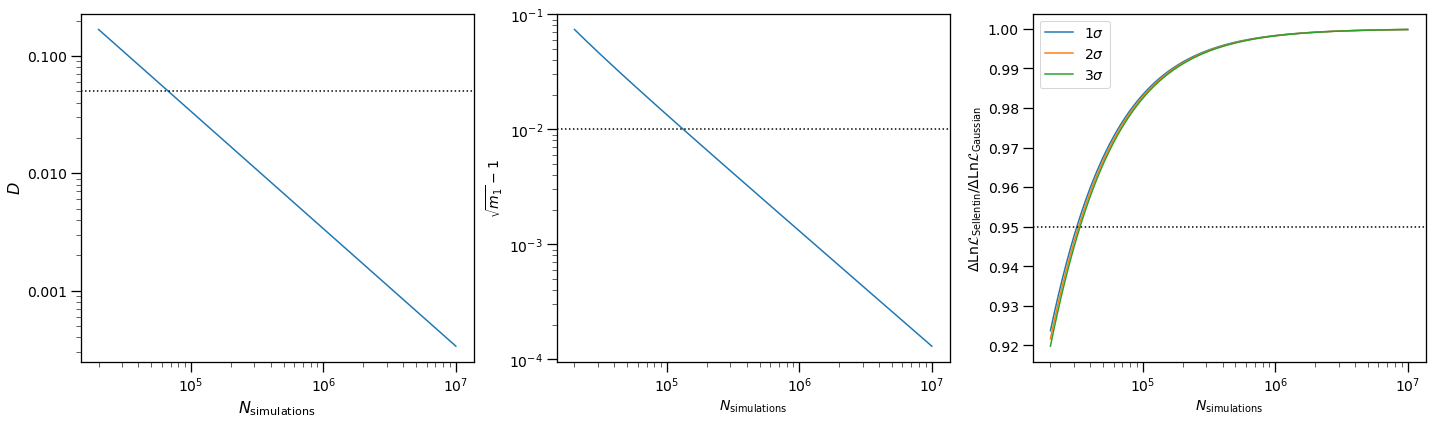

In [175]:
# One scenario - BGS+Baseline
N_sims = np.logspace(np.log10(20000.0), 7.0, 1000)
Nb = np.sum(Nk_BGS) + np.sum(Nk_Baseline)
Np = np.sum(N_nuisance_BGS) + np.sum(N_nuisance_Baseline) + n_cosmo

# Return the values for the current scenario if we have 1000 or 2000 mocks
computation(np.array([1000, 2000]), [Nb], [Np], do_print=True)

# Plot the values for the current scenario as a function of N_mocks
plot_things(N_sims, [Nb], [Np])

# Work out the minimum number of mocks needed to pass the thresholds
how_many_mocks([Nb], [Np])

## Split up BGS and Baseline, making enough mocks for each part - More efficient.

A better approach would be to produce separate sets of BGS and Baseline mocks as these are non-overlapping, and then make sure that each of these covariance matrices is computed with a sufficient number of mocks. When performing joint fits, the two can then be added together assuming no overlap between BGS and Baseline. Note, that when computing the two separate Percival $m_{1}$ factors, I've accounted for cosmology parameters in both, which is effectively double counting these, but would actually be the appropriate thing to do if we were attempting to fit cosmology to just BGS or Baseline. I'm not sure of the correct method to do the combined analysis, but it should only be a small effect given the number of nuisance parameters and measurment bins are much larger.

Scenario 1
-----------------
Hartlap D Factor
 0.27627627627627627 

Percival m1 Factor
 1.207955370665303 

Sellentin/Gaussian Ratio (1-sigma)
 [0.88041474] 

Sellentin/Gaussian Ratio (2-sigma)
 [0.86979271] 

Sellentin/Gaussian Ratio (3-sigma)
 [0.859942] 

Passes Thresholds?
 [False] 

WARNING - Unphysical scenarios present (data vector larger than N_sims)
Scenario 2
-----------------
Hartlap D Factor
 3.084084084084084 

Percival m1 Factor
 -0.38211899807220584 

Sellentin/Gaussian Ratio (1-sigma)
 [0.45426024] 

Sellentin/Gaussian Ratio (2-sigma)
 [0.44779116] 

Sellentin/Gaussian Ratio (3-sigma)
 [0.44205585] 

Passes Thresholds?
 [False] 



<ipython-input-173-452139dbe7f0>:57: RuntimeWarning: invalid value encountered in sqrt
  ax2.loglog(N_sims, np.sqrt(m1)-1.0, ls=ls[i])
<ipython-input-173-452139dbe7f0>:13: RuntimeWarning: invalid value encountered in log
  Sellentin = [-N_sims/2.0 * np.log(1.0 + np.outer(delta_chi_i, 1.0/(N_sims - 1.0))) for delta_chi_i in delta_chi]


Scenario 1 needs at least 8281 mocks
Scenario 2 needs at least 123503 mocks


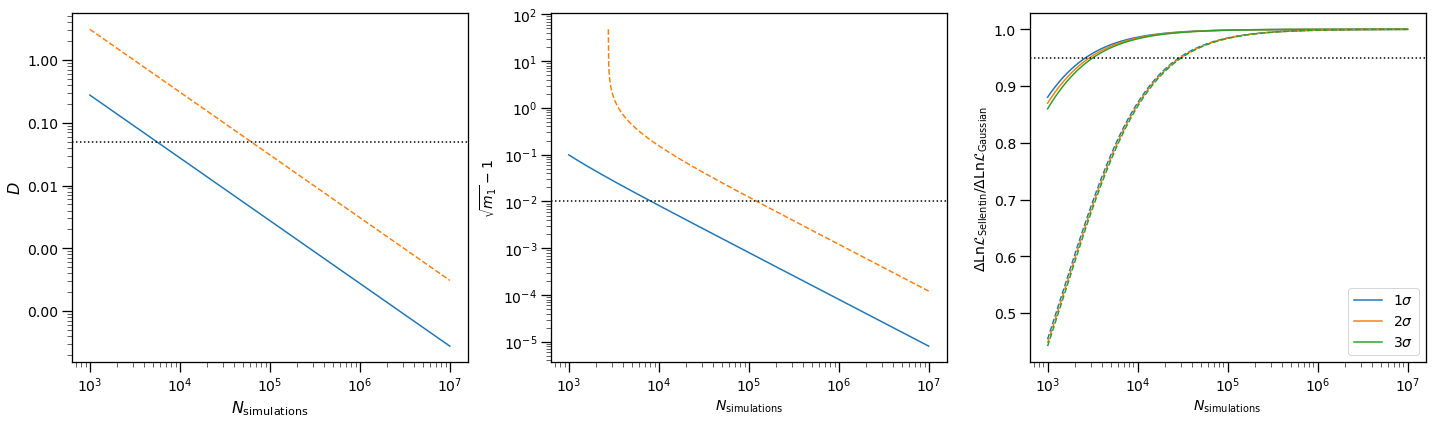

In [176]:
# Two scenarios - BGS and Baseline
N_sims = np.logspace(3.0, 7.0, 1000)
Nb_BGS, Nb_Baseline = np.sum(Nk_BGS), np.sum(Nk_Baseline), 
Np_BGS, Np_Baseline = np.sum(N_nuisance_BGS) + n_cosmo, np.sum(N_nuisance_Baseline) + n_cosmo

# Return the values for the current scenario if we have 1000 mocks
computation(1000, [Nb_BGS, Nb_Baseline], [Np_BGS, Np_Baseline], do_print=True)

# Plot the values for the current scenario as a function of N_mocks
plot_things(N_sims, [Nb_BGS, Nb_Baseline], [Np_BGS, Np_Baseline])

# Work out the minimum number of mocks needed to pass the thresholds
how_many_mocks([Nb_BGS, Nb_Baseline], [Np_BGS, Np_Baseline])

## Make enough mocks for each redshift bin independently - Even more efficient.

A far better approach would be to produce separate mocks for each redshift bin. We then check that the number of mocks for each redshift bin is good enough, and put them all together into a single joint matrix setting the cross-covariance between bins to zero. The total number of mocks would then be the sum of the minimum required in each bin, over all redshift bins, and over all non-correlated sky patches. Again, in the below calculation I've accounted for the cosmology parameters within each $m_{1}$.

Scenario 1
-----------------
Hartlap D Factor
 [0.05605606 0.02801401] 

Percival m1 Factor
 [1.02293835 1.01122969] 

Sellentin/Gaussian Ratio (1-sigma)
 [0.97235457 0.98591495] 

Sellentin/Gaussian Ratio (2-sigma)
 [0.96571289 0.98245324] 

Sellentin/Gaussian Ratio (3-sigma)
 [0.95903909 0.97894389] 

Passes Thresholds?
 [False  True] 

Scenario 2
-----------------
Hartlap D Factor
 [0.05605606 0.02801401] 

Percival m1 Factor
 [1.02293835 1.01122969] 

Sellentin/Gaussian Ratio (1-sigma)
 [0.97235457 0.98591495] 

Sellentin/Gaussian Ratio (2-sigma)
 [0.96571289 0.98245324] 

Sellentin/Gaussian Ratio (3-sigma)
 [0.95903909 0.97894389] 

Passes Thresholds?
 [False  True] 

Scenario 3
-----------------
Hartlap D Factor
 [0.05605606 0.02801401] 

Percival m1 Factor
 [1.02293835 1.01122969] 

Sellentin/Gaussian Ratio (1-sigma)
 [0.97235457 0.98591495] 

Sellentin/Gaussian Ratio (2-sigma)
 [0.96571289 0.98245324] 

Sellentin/Gaussian Ratio (3-sigma)
 [0.95903909 0.97894389] 

Passes Thresh

<ipython-input-173-452139dbe7f0>:13: RuntimeWarning: invalid value encountered in log
  Sellentin = [-N_sims/2.0 * np.log(1.0 + np.outer(delta_chi_i, 1.0/(N_sims - 1.0))) for delta_chi_i in delta_chi]


Scenario 1 needs at least 1136 mocks
Scenario 2 needs at least 1136 mocks
Scenario 3 needs at least 1136 mocks
Scenario 4 needs at least 1136 mocks
Scenario 5 needs at least 1136 mocks
Scenario 6 needs at least 5714 mocks
Scenario 7 needs at least 13083 mocks
Scenario 8 needs at least 13083 mocks
Scenario 9 needs at least 13083 mocks
Scenario 10 needs at least 13083 mocks
Scenario 11 needs at least 13083 mocks
Scenario 12 needs at least 13083 mocks
Scenario 13 needs at least 5714 mocks
Scenario 14 needs at least 5714 mocks
Scenario 15 needs at least 5714 mocks
Scenario 16 needs at least 5714 mocks
Scenario 17 needs at least 5714 mocks
Scenario 18 needs at least 1136 mocks
Scenario 19 needs at least 1136 mocks


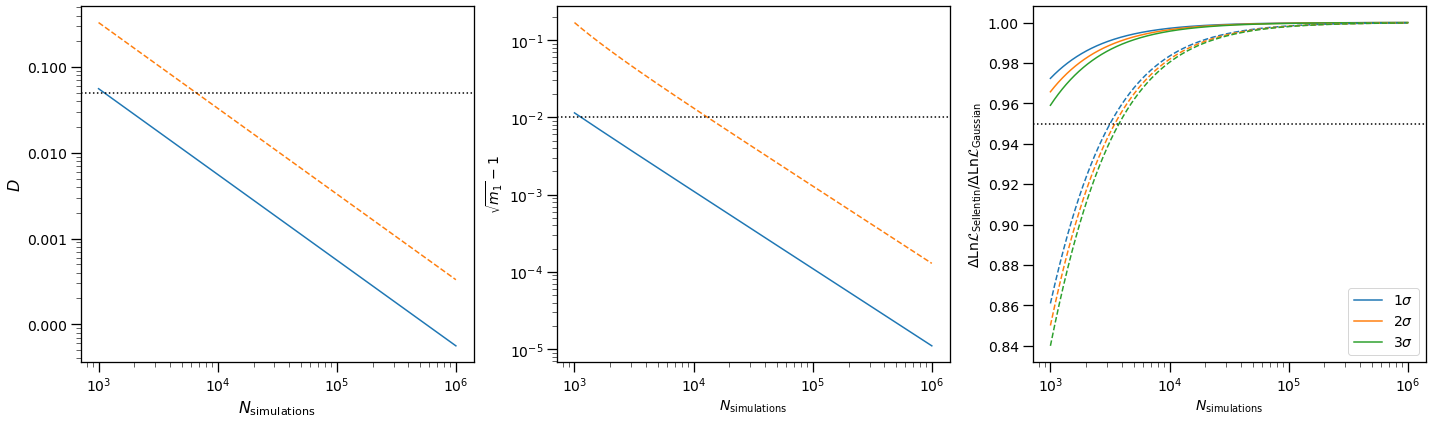

In [177]:
# Each redshift bin is a different Scenario
N_sims = np.logspace(3.0, 6.0, 1000)
Nb = np.concatenate([Nk_BGS, Nk_Baseline])
Np = np.concatenate([N_nuisance_BGS, N_nuisance_Baseline]) + n_cosmo

# Return the values for the current scenario if we have 1000 or 2000 mocks
computation(np.array([1000, 2000]), Nb, Np, do_print=True)

# Plot the values for the current scenario as a function of N_mocks (just plot min and max)
plot_things(N_sims, [np.amin(Nb), np.amax(Nb)], [np.amin(Np), np.amax(Np)])

# Work out the minimum number of mocks needed to pass the thresholds
how_many_mocks(Nb, Np)

## Make enough lightcone mocks for redshift bin with largest data vector, and use to construct all redshift slices - Most efficient?

The most efficient approach is potentially to have a single series of lightcone mocks that can be used to construct the covariance matrix for each redshift slice, before these are concatenated together assuming no cross-correlation between redshift bins. The computation would be the same as the above scenario, so no need to repeat it, but rather than summing the minimum number required for each z-bin, we could conceivably just produce enough sims for the redshift bin with the largest data vector. If the covariance matrix is accurate enough for this bin, it will be accurate enough for other bins. A point of note is that although we are forcing the cross-covariance between z-bins to be zero, in truth the mocks include long-wavelength modes (just like the real Universe). These long wavelength modes will have affected the structure in the mocks and hence we would have potentially a different covariance matrix than the above approach where mocks are generated independently for each z-bin.